In [57]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.colors import hsv_to_rgb
import trimesh
import os
from PIL import Image
import tempfile
import shutil
import sys

sys.path.append("/home/arno/Projects/Pint3D/print_ngp/util")
from printer.printerICM import getVoxelSize, convert_color_profile


目的：看一下volume版本的色轮怎么样。一个三个对比：

1. mesh打印的版本
2. volume带icc
3. volume带icc带颜色重排

根据之前打出来的尺寸，生成一个对应的volume。

In [7]:
# 测量得到之前打的直径50，高度5
x_size, y_size, z_size = getVoxelSize()
print(x_size, y_size, z_size)
volume_size = (50/x_size, 50/y_size, 5/z_size)
volume_size = (int(volume_size[0]), int(volume_size[1]), int(volume_size[2]))
print(volume_size)

0.084 0.028 0.014
(595, 1785, 357)


In [19]:
volume=np.zeros(volume_size + (4,), dtype=np.float32) # RGBA 格式
# 计算中心点
center_x = volume_size[0] // 2
center_y = volume_size[1] // 2
# 取中心是白色
volume[center_x, center_y, :] = [1, 1, 1, 1]
# 对于其他的点，计算极坐标
for x in range(volume_size[0]):
    for y in range(volume_size[1]):
        dx = (x - center_x) *x_size
        dy = (y - center_y) *y_size
        r = np.sqrt((dx/50)**2 + (dy/50)**2)
        theta = np.arctan2(dy, dx)
        if theta < 0:
            theta += 2 * np.pi
        # 计算HSV颜色
        h = theta / (2 * np.pi)
        s = r
        v = 1.0
        rgb = hsv_to_rgb([h, s, v])
        rgba = np.concatenate([rgb, [1]])
        volume[x, y, :] = rgba



In [46]:
import numpy as np
from matplotlib.colors import hsv_to_rgb

# 创建体积数据
volume = np.zeros(volume_size + (4,), dtype=np.float32)  # RGBA 格式

# 计算中心点
center_x = volume_size[0] // 2
center_y = volume_size[1] // 2

# 取中心是白色
volume[center_x, center_y, :] = [1, 1, 1, 1]

# 使用NumPy向量化替代双层循环
x_indices, y_indices = np.meshgrid(np.arange(volume_size[0]), np.arange(volume_size[1]), indexing='ij')
dx = (x_indices - center_x) * x_size
dy = (y_indices - center_y) * y_size
r = np.sqrt((dx/50)**2 + (dy/50)**2)
theta = np.arctan2(dy, dx)
theta = np.where(theta < 0, theta + 2 * np.pi, theta)

# 计算HSV颜色
h = theta / (2 * np.pi)
s = r
v = np.ones_like(r)

# 创建HSV数组
hsv_array = np.stack([h, s, v], axis=2)

# 转换HSV到RGB
rgb_array = hsv_to_rgb(hsv_array)
# 将RGB数组复制到volume的每一层
for z in range(volume_size[2]):
    volume[:, :, z, :3] = rgb_array
    volume[:, :, z, 3] = 1.0  # 设置alpha通道为1

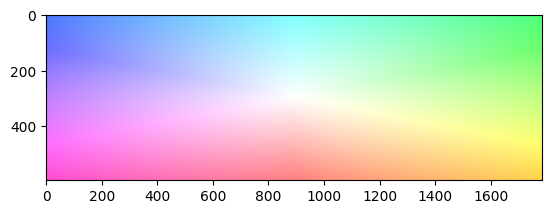

In [49]:
# 可视化这个RGBA图片
plt.imshow(rgb_array)
plt.show()


In [53]:
%pwd

'/home/arno/Projects/Pint3D/print_ngp/Mesh2Volume'

In [56]:
# 使用压缩格式保存Volume
np.savez_compressed("ColorWheel/volumeWheel/colorWheelVolume.npz", volume= np.transpose(volume, (2, 0, 1, 3))) # 保存的格式是(z, x, y, c)